In [1]:
import os 
import sys

%matplotlib inline
import matplotlib.pyplot as plt

from desilike.samples import Profiles, Chain, plotting

plt.style.use(os.path.join(os.path.abspath('../bin'), 'plot_style.mplstyle'))
plots_dir = '../../plots/'

In [2]:
tracer = 'ELG_LOP'
region = 'GCcomb'
zrange = (1.1, 1.6)
z = 1.325
ktlim = (0.001, 0.35)
version = 'v4_1fixran'
completeness = 'complete'
data_dir = '/global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/{}'.format(version)
covtype = 'ezmocks'
template_name = 'shapefitqisoqap'
thetacut = 0.05
shotnoise = True

In [3]:
sys.path.append('../bin')
from emulator_fit import get_observable_likelihood

output_dir = '/global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/{}/'.format(version)
emulator_dir = os.path.join(output_dir, 'emulators', 'emulators_{}_{}_z{:.3f}'.format(template_name, tracer[:7], z))
emulator_fn=os.path.join(emulator_dir, '{}_{{}}.npy'.format('power'))
chains_dir = os.path.join(data_dir, 'chains', 'chains_{}_{{}}_z{:.3f}-z{:.3f}_{{}}_{}'.format(template_name, zrange[0], zrange[1], region), 'physicalpriorbasis')

In [4]:
chain = Chain.concatenate([Chain.load(os.path.join(chains_dir.format(tracer[:7], 'complete'), 'power_velocileptors_{}cov_thetacut0.05{}_{:d}.npy'.format(covtype, '_withshotnoise' if shotnoise else '', i))).remove_burnin(0.5)[::10] for i in range(8)])

In [5]:
likelihood_nocut = []
likelihood = []
likelihood_rot = []

ktmaxvals = [0.25, 0.3, 0.35, 0.4, 0.45, 0.5]

for ktmax in ktmaxvals:
    like_nocut = get_observable_likelihood(catalog='second', version=version, tracer=tracer, region=region, z=z, zrange=zrange, completeness='complete',
                                       xinlim=(0.001, ktmax), theory_name='velocileptors', template_name=template_name, 
                                       covtype=covtype, emulator_fn=emulator_fn, solve=True, rpcut=0, thetacut=0, withshotnoise=shotnoise)
    like = get_observable_likelihood(catalog='second', version=version, tracer=tracer, region=region, z=z, zrange=zrange, completeness='complete',
                                       xinlim=(0.001, ktmax), theory_name='velocileptors', template_name=template_name, 
                                       covtype=covtype, emulator_fn=emulator_fn, solve=True, rpcut=0, thetacut=thetacut, withshotnoise=shotnoise)
    like_rot = get_observable_likelihood(catalog='second', version=version, tracer=tracer, region=region, z=z, zrange=zrange, completeness='complete',
                                       xinlim=(0.001, ktmax), theory_name='velocileptors', template_name=template_name, 
                                       covtype=covtype, emulator_fn=emulator_fn, solve=True, rpcut=0, thetacut=thetacut, sculpt_window=True, systematic_priors=1, withshotnoise=shotnoise)

    like_nocut(chain.choice(index='argmax', input=True))
    like(chain.choice(index='argmax', input=True))
    like_rot(chain.choice(index='argmax', input=True))
    likelihood_nocut.append(like_nocut)
    likelihood.append(like)
    likelihood_rot.append(like_rot)

EZmocks covariance.
Loading EZmocks covariance: /global/cfs/cdirs/desi/users/mpinon/Y1/cov/pk/cov_EZmocks_ELG_LOP_ffa_GCcomb_z1.100-1.600_k0.02-0.20.npy
Covariance matrix with 108 points built from 1000 observations, resulting in a Hartlap 2007 factor of 0.8909.
Template shapefitqisoqap at redshift z = 1.325.
Emulator path: /global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/v4_1fixran/emulators/emulators_shapefitqisoqap_ELG_LOP_z1.325/power_velocileptors.npy
Shot noise included in the observable.
EZmocks covariance.
Loading EZmocks covariance: /global/cfs/cdirs/desi/users/mpinon/Y1/cov/pk/cov_EZmocks_ELG_LOP_ffa_GCcomb_z1.100-1.600_k0.02-0.20_thetacut0.05.npy
Covariance matrix with 108 points built from 1000 observations, resulting in a Hartlap 2007 factor of 0.8909.
Template shapefitqisoqap at redshift z = 1.325.
Emulator path: /global/cfs/cdirs/desi/users/mpinon/secondGenMocksY1/v4_1fixran/emulators/emulators_shapefitqisoqap_ELG_LOP_z1.325/power_velocileptors.npy
Shot noise include

In [6]:
#likelihood_rotated_ktmax035(chain.choice(index='argmax', input=True))
#likelihood_rotated_ktmax04(chain_ktmax04.choice(index='argmax', input=True))
#likelihood_rotated_ktmax045(chain_ktmax045.choice(index='argmax', input=True))

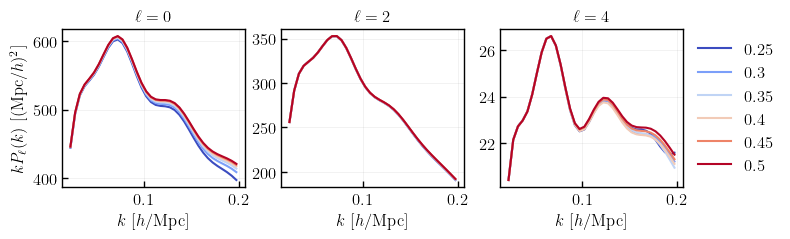

In [7]:
ells = (0, 2, 4)

plt.rcParams["figure.autolayout"] = False
fig, axes = plt.subplots(1, 3, figsize=(8, 2.5), sharey=False)

cmap = plt.get_cmap('coolwarm', len(ktmaxvals))
colors = [cmap(i) for i in range(len(ktmaxvals))]

for j, kt in enumerate(ktmaxvals):
    for i, ell in enumerate(ells):
        k = likelihood_nocut[j].observables[0].k
        pk_nocut = likelihood_nocut[j].observables[0].theory
        axes[i].plot(k[i], k[i] * pk_nocut[i], label=r'${}$'.format(kt), color=colors[j])
        axes[i].set_title(r'$\ell = {}$'.format(ell))
        axes[i].set_xlabel(r'$k$  [$h$/Mpc]')

axes[0].set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')
axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.savefig(os.path.join(plots_dir, version, 'windowed_theory_varyingktmax_complete_nocut_{}_{}_z{:.2f}-{:.2f}{}.pdf'.format(tracer, region, zrange[0], zrange[1], '_withshotnoise' if shotnoise else '')), dpi=200)
plt.show()

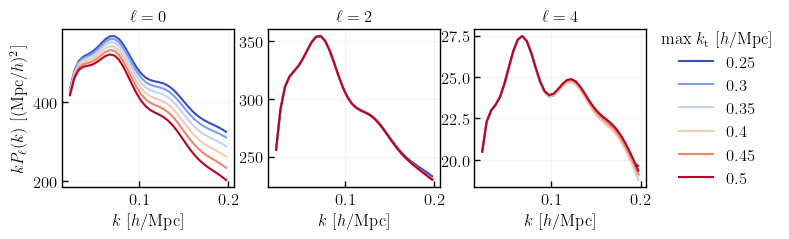

In [8]:
ells = (0, 2, 4)

fig, axes = plt.subplots(1, 3, figsize=(8, 2.5), sharey=False)

for j, kt in enumerate(ktmaxvals):
    for i, ell in enumerate(ells):
        k = likelihood[j].observables[0].k
        pk = likelihood[j].observables[0].theory
        axes[i].plot(k[i], k[i] * pk[i], label=r'${}$'.format(kt), color=colors[j])
        axes[i].set_title(r'$\ell = {}$'.format(ell))
        axes[i].set_xlabel(r'$k$  [$h$/Mpc]')

axes[0].set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')    
axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5), title=r'max $k_{\mathrm{t}} \; [h/\mathrm{Mpc}]$')
plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.savefig(os.path.join(plots_dir, version, 'windowed_theory_varyingktmax_complete_thetacut{:.2f}_{}_{}_z{:.2f}-{:.2f}{}.pdf'.format(thetacut, tracer, region, zrange[0], zrange[1], '_withshotnoise' if shotnoise else '')), dpi=200)
plt.show()

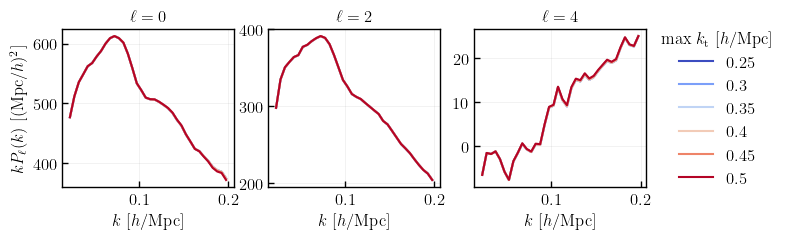

In [9]:
ells = (0, 2, 4)

fig, axes = plt.subplots(1, 3, figsize=(8, 2.5), sharey=False)

for j, kt in enumerate(ktmaxvals):
    for i, ell in enumerate(ells):
        k = likelihood_rot[j].observables[0].k
        pk_rot = likelihood_rot[j].observables[0].theory
        axes[i].plot(k[i], k[i] * pk_rot[i], label=r'${}$'.format(kt), color=colors[j])
        axes[i].set_title(r'$\ell = {}$'.format(ell))
        axes[i].set_xlabel(r'$k$  [$h$/Mpc]')

axes[0].set_ylabel(r'$k P_{\ell}(k)$ [$(\mathrm{Mpc}/h)^{2}$]')    
axes[2].legend(loc='center left', bbox_to_anchor=(1, 0.5), title=r'max $k_{\mathrm{t}} \; [h/\mathrm{Mpc}]$')
plt.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.1)
plt.savefig(os.path.join(plots_dir, version, 'rotated_windowed_theory_varyingktmax_complete_thetacut{:.2f}_{}_{}_z{:.2f}-{:.2f}{}.pdf'.format(thetacut, tracer, region, zrange[0], zrange[1], '_withshotnoise' if shotnoise else '')), dpi=200)
plt.show()